# Evaluate water mass properties on the shelves using Shenjie's climatology

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io import read_dutrieux, read_zhou
from nemo_python_git.utils import convert_to_teos10, distance_btw_points, closest_point
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.plots import circumpolar_plot, finished_plot

In [3]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

## Look at Shenjie Zhou's observational dataset

In [4]:
obs = read_zhou()

In [5]:
# extract the bottom temperatures and salinities 
depth_bottom_obs = xr.where(obs['ConsTemp'].notnull(),obs['depth'],np.nan).max(dim='z')
depth_bottom_obs = xr.where(depth_bottom_obs < 200, np.nan, depth_bottom_obs) # mask areas shallower than 200 m
bottom_Tobs      = obs['ConsTemp'].where(~np.isnan(depth_bottom_obs)).mean(dim='z')
bottom_Sobs      = obs['AbsSal'].where(~np.isnan(depth_bottom_obs)).mean(dim='z')

obs_bottom = xr.Dataset({'temp':bottom_Tobs, 'salt':bottom_Sobs, 'depth':depth_bottom_obs})

In [6]:
# load nemo grid for interpolation
nemo_ds_ref  = xr.open_dataset(f'{run_folder}eANT025.L121_1m_19790101_19791231_grid_T.nc') # load all the gridT files in the run folder
nemo_ds_ref  = nemo_ds_ref.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})

In [ ]:
obs_interp = interp_latlon_cf(obs_bottom, nemo_ds_ref.isel(x=slice(450, 900), y=slice(130,350)), method='bilinear')

## Also look at moorings:

In [5]:
files = glob.glob('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/shenjie-zhou/mooring/*.nc')

In [30]:
mooring1  = xr.open_dataset(files[0], decode_times=False).squeeze()
mooring2  = xr.open_dataset(files[1], decode_times=False).squeeze()
mooring10 = xr.open_dataset(files[10], decode_times=False).squeeze()

In [31]:
list(mooring10.keys())

['lat',
 'lon',
 'bottom_depth',
 'doi',
 'Instrument_01_date',
 'Instrument_01_depth',
 'Instrument_01_press',
 'Instrument_01_temp',
 'Instrument_01_u',
 'Instrument_01_v',
 'Instrument_02_date',
 'Instrument_02_depth',
 'Instrument_02_press',
 'Instrument_02_temp',
 'Instrument_02_u',
 'Instrument_02_v']

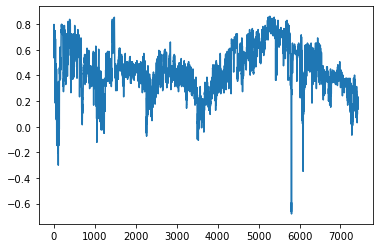

In [34]:
plt.plot(mooring10.Instrument_01_temp.values)

In [15]:
a = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/110036.nc').squeeze()